In [14]:
import dgl

import torch
import torch.nn as nn

import pytorch_lightning as pl

import networkx as nx

from data import pert_S

from arch.model import Model1, Model2

from dgl.nn import GATConv, GraphConv

import numpy as np

import matplotlib.pyplot as plt

In [15]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [16]:
def get_data(dataset_class):
    dataset = getattr(dgl.data, dataset_class)(verbose=False)
    g = dataset[0]
    num_class = dataset.num_classes

    # get node feature
    feat = g.ndata['feat'].to(device)

    # get data split
    train_mask = g.ndata['train_mask'].to(device)
    val_mask = g.ndata['val_mask'].to(device)
    test_mask = g.ndata['test_mask'].to(device)

    # get labels
    label = g.ndata['label'].to(device)
    N = g.number_of_nodes()
    n_feat = feat.shape[1]

    S = g.adj().to_dense().numpy()

    return S, feat, label, n_feat, num_class, train_mask, val_mask, test_mask

In [17]:
S, feat, label, n_feat, num_class, train_mask, val_mask, test_mask = get_data("CoraGraphDataset")

In [18]:
n_epochs = 50
lr = 5e-3
wd = 5e-4
eval_freq = 50

n_iters = 50

hid_dim = 16
n_layers = 2
model_params = {
    'in_dim': n_feat,
    'hid_dim': hid_dim,
    'out_dim': num_class,
    'n_layers': n_layers,
    'K': 4
}

model_params_m2 = {
    'in_dim': n_feat,
    'hid_dim': hid_dim,
    'out_dim': num_class,
    'n_layers': n_layers
}

gamma = 0.1
beta = 0.01
lambd = 0.1

In [19]:
Sn = torch.Tensor(pert_S(S, eps=0.1)).to(device)

In [20]:
model = Model1(Sn, n_epochs, lr, wd, eval_freq, model_params, n_iters)
model.model = model.model.to(device)

accs_train, accs_test, S_id = model.test_model(Sn, feat, label, lambd, beta, merge_theta_H=True, train_idx=train_mask, val_idx=val_mask, test_idx=test_mask, verbose=True)

Epoch 1/50 - Loss: 838.90966796875 - Train Acc: 0.02857142857142857 - Test Acc: 0.107
Epoch 50/50 - Loss: 19.301616668701172 - Train Acc: 0.6642857142857143 - Test Acc: 0.542
Iteration 1 DONE - Acc Test: 0.542 - Err Sn: 1.0
Epoch 1/50 - Loss: 1.9063513278961182 - Train Acc: 0.2714285714285714 - Test Acc: 0.206
Epoch 50/50 - Loss: 1.9027690887451172 - Train Acc: 0.2785714285714286 - Test Acc: 0.204
Iteration 2 DONE - Acc Test: 0.204 - Err Sn: 0.9000000357627869
Epoch 1/50 - Loss: 1.8164821863174438 - Train Acc: 0.3357142857142857 - Test Acc: 0.263
Epoch 50/50 - Loss: 1.7999110221862793 - Train Acc: 0.3357142857142857 - Test Acc: 0.262
Iteration 3 DONE - Acc Test: 0.262 - Err Sn: 0.8100000619888306
Epoch 1/50 - Loss: 2.162832498550415 - Train Acc: 0.4 - Test Acc: 0.321
Epoch 50/50 - Loss: 1.4040088653564453 - Train Acc: 0.4714285714285714 - Test Acc: 0.384
Iteration 4 DONE - Acc Test: 0.384 - Err Sn: 0.7200000286102295
Epoch 1/50 - Loss: 1.2160565853118896 - Train Acc: 0.5285714285714286

In [26]:
model.model.convs[0].W

Parameter containing:
tensor([[-0.2612,  0.0615, -0.0326,  ..., -0.0007, -0.3409,  0.0671],
        [ 0.0483,  0.4926, -0.0569,  ...,  0.0653,  0.0533, -0.3239],
        [-0.0602,  0.1949, -0.0626,  ..., -0.4826, -0.4732, -0.0571],
        ...,
        [ 0.2003, -0.1615, -0.4625,  ...,  0.6054, -0.1228,  0.0441],
        [ 0.2557,  0.5278,  0.3968,  ..., -0.5445,  0.0234, -0.3099],
        [-0.0681,  0.6139,  0.1642,  ..., -0.0422, -0.4243,  0.2183]],
       device='cuda:1', requires_grad=True)

In [21]:
accs_test[-1,-1]

0.644

In [22]:
norm_S = np.sqrt((S**2).sum())
torch.sqrt(((S_id - torch.Tensor(S).to(device))**2).sum()) / norm_S, torch.sqrt(((S_id - Sn)**2).sum()) / norm_S

(tensor(0.6192, device='cuda:1'), tensor(0.5400, device='cuda:1'))

In [10]:
model = Model2(Sn, n_epochs, lr, wd, eval_freq, model_params_m2, n_iters)
model.model = model.model.to(device)

accs_train, accs_test, S_id = model.test_model(Sn, feat, label, lambd, gamma, beta, merge_theta_H=False, train_idx=train_mask, val_idx=val_mask, test_idx=test_mask)

In [11]:
accs_test[-1,-1]

0.073

In [12]:
torch.sqrt(((S_id - torch.Tensor(S).to(device))**2).sum()) / norm_S, torch.sqrt(((S_id - Sn)**2).sum()) / norm_S

(tensor(17.1413, device='cuda:1'), tensor(43.9051, device='cuda:1'))

In [13]:
(S_id==0.).sum() / (S_id.shape[0]*S_id.shape[1]), (S==0.).sum() / (S.shape[0]*S.shape[1])

(tensor(0.3365, device='cuda:1'), 0.9985605318450284)

# Other GNN testing - For Future comparison

In [5]:
def evaluate(g, features, labels, mask, model):
    model.eval()
    with torch.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

def test(model, g, feat, label, train_mask, val_mask, test_mask, verbose=True):
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    loss_fn = torch.nn.CrossEntropyLoss()

    loss_train, acc_train, acc_test = [torch.zeros(n_epochs) for _ in range(3)]

    for i in range(n_epochs):
        y_hat = model(g, feat)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = loss_fn(y_hat[train_mask], label[train_mask])

        opt.zero_grad()
        loss.backward()
        opt.step()

        # Compute accuracy on training/validation/test
        train_acc = evaluate(g, feat, label, train_mask, model)
        val_acc = evaluate(g, feat, label, val_mask, model)
        test_acc = evaluate(g, feat, label, test_mask, model)

        loss_train[i] = loss.detach().cpu().item()
        acc_train[i] = train_acc
        acc_test[i] = test_acc

        if (i == 0 or (i+1) % eval_freq == 0) and verbose:
            print(f"Epoch {i+1}/{n_epochs} - Loss Train: {loss_train[i]} - Acc Train: {acc_train[i]} - Acc Val: {val_acc} - Acc Test: {acc_test[i]}", flush=True)

    return loss_train, acc_train, acc_test

In [11]:
hid_dim_gcn = 16

hid_dim_gat = 8
num_heads = 8
gat_params = {
    'feat_drop': 0.6,
    'attn_drop': 0.6
}

In [12]:
EXPS = [
    {
        "dataset": "Cora",
        "layer": "GCN",
        "legend": "Cora-GCN",
        "fmt": "d-"
    },
    {
        "dataset": "Citeseer",
        "layer": "GCN",
        "legend": "Citeseer-GCN",
        "fmt": "v-"
    },
    {
        "dataset": "Cora",
        "layer": "GAT",
        "legend": "Cora-GAT",
        "fmt": "s-"
    },
    {
        "dataset": "Citeseer",
        "layer": "GAT",
        "legend": "Citeseer-GAT",
        "fmt": "v-"
    },
]

In [13]:
class GAT(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = GATConv(in_dim, hidden_dim, num_heads)
        # Be aware that the input dimension is hidden_dim*num_heads since
        # multiple head outputs are concatenated together. Also, only
        # one attention head in the output layer.
        self.layer2 = GATConv(hidden_dim * num_heads, out_dim, 1)
        self.nonlin = nn.ELU()

    def forward(self, graph, h):
        h = self.layer1(graph, h)
        # concatenate
        h = h.flatten(1)
        h = self.nonlin(h)
        h = self.layer2(graph, h)
        return h.squeeze()

In [14]:
class GCN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(GCN, self).__init__()
        self.layer1 = GraphConv(in_dim, hidden_dim)
        self.layer2 = GraphConv(hidden_dim, out_dim)
        self.nonlin = nn.Tanh()

    def forward(self, graph, h):
        h = self.layer1(graph, h)
        h = self.nonlin(h)
        h = self.layer2(graph, h)
        return h

In [15]:
perts = [0., 0.05, 0.1, 0.15, 0.2, 0.25]

n_graphs = 25

accs_test = np.zeros((n_graphs, len(EXPS), len(perts)))
for i, p in enumerate(perts):

    for j, exp in enumerate(EXPS):

        S, feat, label, in_dim, out_dim, train_mask, val_mask, test_mask = get_data(exp['dataset'] + "GraphDataset")

        print(f"Starting pert {p} of exp {exp['dataset']} - {exp['layer']}: ", end="")

        for n in range(n_graphs):
            print(f"{n+1} ", end="")
            
            S_pert = pert_S(S.copy(), eps=p)
            if p == 0.:
                assert np.all(S_pert == S)

            g = dgl.from_networkx(nx.from_numpy_array(S_pert)).add_self_loop().to('cuda')

            if exp['layer'] == "GCN":
                model = GCN(in_dim, hid_dim_gcn, out_dim).to('cuda')
            elif exp['layer'] == "GAT":
                model = GAT(in_dim, hid_dim_gat, out_dim, num_heads **gat_params).to('cuda')

            loss_train, acc_train, acc_test = test(model, g, feat, label, train_mask, val_mask, test_mask, False)

            accs_test[n, j, i] = acc_test[-1]
        print(f"DONE - Accuracy Test: {np.mean(accs_test, 0)[j,i]}")

Starting pert 0.0 of exp Cora - GCN: 1 2 3 4 5 6 7 8 

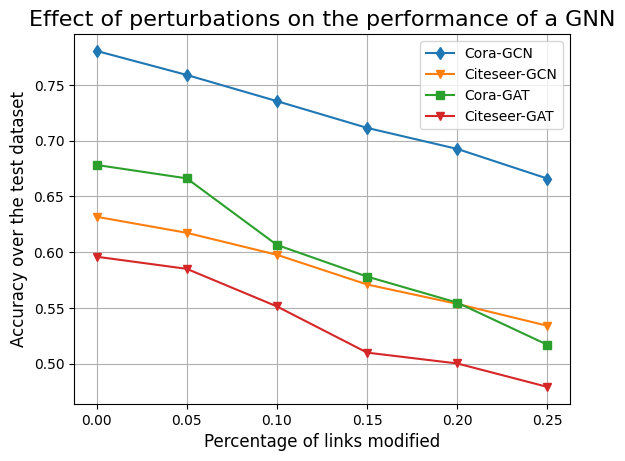

In [ ]:
for i, exp in enumerate(EXPS):
    plt.plot(perts, accs_test.mean(0)[i,:], exp["fmt"], label=exp["legend"])

plt.xlabel("Percentage of links modified", fontsize=12)
plt.ylabel("Accuracy over the test dataset", fontsize=12)
plt.title("Effect of perturbations on the performance of a GNN", fontsize=16)
plt.legend()
plt.grid()